### Imitation Learning to replace IDM vehicles (represented by a neural network)
- Inputs: 
    - Headway distance (normalized by 100) to the leader# m
    - Ego Velocity (normalized by 30) # m/s
    - Leader Velocity (normalized by 30) # m/s

- Output:
    - Acceleration (m/$s^2$). Not manipulated in any way (whatever is present in the data)

- TODO: 
    - Just add some dropout and basic L2 regularization to improve performance.


In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

import torch 
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


In [2]:
columns = ['direction', 'id', 't', 'x', 'lane_id', 'leader_id', 'headway', 'ego_velocity', 'acceleration']
data = pd.read_csv('./velocity_acceleration_i24.csv', names=columns)
print(data.shape)
data.head()

(274507, 9)


,direction,id,t,x,lane_id,leader_id,headway,ego_velocity,acceleration
0,-1,638c27c03fc03ef13312f609,1.669132e+09,99900.141021,1,638c1aeda5b418cbd77134da,6.397655,NaN,NaN
1,-1,638c27c03fc03ef13312f609,1.669132e+09,99896.108924,1,638c1aeda5b418cbd77134da,6.143910,-33.600839,NaN
2,-1,638c27c03fc03ef13312f609,1.669132e+09,99893.414223,1,638c1aeda5b418cbd77134da,5.986429,-33.683692,-1.035661
3,-1,638c27c03fc03ef13312f609,1.669132e+09,99889.362113,1,638c1aeda5b418cbd77134da,5.767615,-33.767543,-0.698756
4,-1,638c27c03fc03ef13312f609,1.669132e+09,99838.225014,2,638c1aeda5b418cbd77134da,4.833364,-34.552094,-0.530102


In [3]:
# Create a new column, leader_x which is obtained using headway and x of ego
# If direction = -1, as leader moves forward the x values decrease. So leader_x = x - headway
# If direction = 1, as leader moves forward the x values increase. So leader_x = x + headway 
# print sample direction = 1 values
# print(data[data['direction'] == 1].head())

data['leader_x'] = data['x'] + data['headway'] * data['direction']
# print(data.head())
# print(data[data['direction'] == 1].head())

# Differentiate the leader_x to calculate leader velocity 
def calculate_velocity(df):
    # sort by timesteps 
    df = df.sort_values('t')
    
    # Calculate the time diff as well as x diff 
    df['dt'] = df['t'].diff()
    df['dx'] = df['leader_x'].diff()

    # Calculate velocity as dx/dt
    df['leader_velocity'] = df['dx'] / df['dt']
    
    # drop 
    df.drop(columns=['dt', 'dx'], axis=1, inplace=True)   
    return df

#csv_file_path = './complete_dataset.csv'

# For a current ego vehicle, leader may change so groupby ego_id, leader_id
groups = data.groupby(['id', 'leader_id'])
print(f"Found {len(groups)} groups")

results = [] 
for i, (group_name, group) in enumerate(groups):
    results.append(calculate_velocity(group))

    if i %2000==0:
        print(f"Processed {i} groups")
    
        results_df = pd.concat(results)

results_df.head() 

Found 8098 groups
Processed 0 groups
Processed 2000 groups
Processed 4000 groups
Processed 6000 groups
Processed 8000 groups


,direction,id,t,x,lane_id,leader_id,headway,ego_velocity,acceleration,leader_x,leader_velocity
0,-1,638c27c03fc03ef13312f609,1.669132e+09,99900.141021,1,638c1aeda5b418cbd77134da,6.397655,NaN,NaN,99893.743365,NaN
1,-1,638c27c03fc03ef13312f609,1.669132e+09,99896.108924,1,638c1aeda5b418cbd77134da,6.143910,-33.600839,NaN,99889.965014,-31.486291
2,-1,638c27c03fc03ef13312f609,1.669132e+09,99893.414223,1,638c1aeda5b418cbd77134da,5.986429,-33.683692,-1.035661,99887.427794,-31.715189
3,-1,638c27c03fc03ef13312f609,1.669132e+09,99889.362113,1,638c1aeda5b418cbd77134da,5.767615,-33.767543,-0.698756,99883.594499,-31.944092
4,-1,638c27c03fc03ef13312f609,1.669132e+09,99838.225014,2,638c1aeda5b418cbd77134da,4.833364,-34.552094,-0.530102,99833.391650,-33.920843


In [4]:
# From previous processing, the two initial rows are Nan, when differentiation was performed. From new processing some leader_velocity rows are also Nan. Count all Nans
print(results_df.isna().sum())
print(results_df.shape)

# drop all rows with Nan
results_df = results_df.dropna()
print(results_df.shape)

direction             0
id                    0
t                     0
x                     0
lane_id               0
leader_id             0
headway               0
ego_velocity       4446
acceleration       8801
leader_x              0
leader_velocity    8001
dtype: int64
(271509, 11)
(259265, 11)


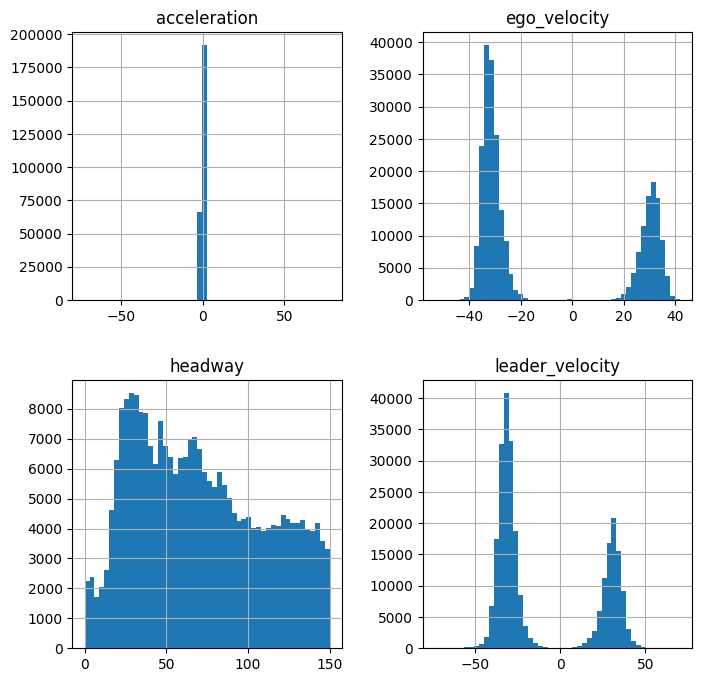

In [5]:
# drop all columns except headway, ego_velocity, leader_velocity, acceleration
selected_df = results_df[['headway', 'ego_velocity', 'leader_velocity', 'acceleration']]

# print the summary statistics of headway, ego_velocity, leader_velocity, acceleration
selected_df.describe()

# Plot the histograms of headway, ego_velocity, leader_velocity, acceleration
selected_df.hist(bins=50, figsize=(8,8))
plt.show()


Max among velocities: 70.53388002651965


/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3683fc5f8>,
      dtype=object)

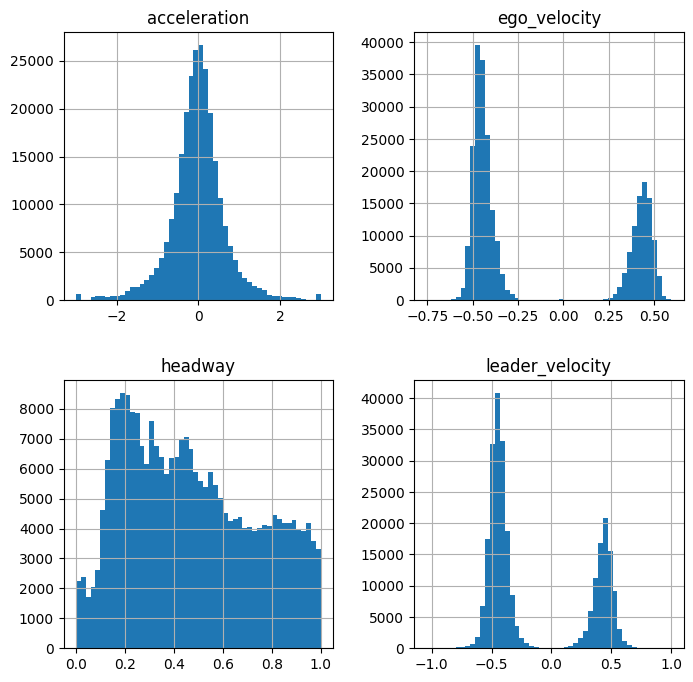

In [6]:
# Normalize velocity with half of  max
max_vel = max(selected_df['ego_velocity'].max(), selected_df['leader_velocity'].max())

print(f"Max among velocities: {max_vel}")
selected_df['ego_velocity'] = selected_df['ego_velocity'] / max_vel
selected_df['leader_velocity'] = selected_df['leader_velocity'] / max_vel

# Normalize the headway with max 
selected_df['headway'] = selected_df['headway'] / selected_df['headway'].max()

# Do not normalize the acceleration. But all acceleration less than -3 are -3 and higher than +3 are +3 
selected_df['acceleration'] = selected_df['acceleration'].clip(-3, 3)

# Plot again 
selected_df.hist(bins=50, figsize=(8,8))

In [7]:
print(selected_df.shape)
selected_df.describe()

(259265, 4)


,headway,ego_velocity,leader_velocity,acceleration
count,259265.000000,259265.000000,259265.000000,259265.000000
mean,0.470035,-0.137505,-0.137455,-0.021145
std,0.262758,0.422391,0.426813,0.671974
min,0.000014,-0.755945,-1.044746,-3.000000
25%,0.244027,-0.465134,-0.467679,-0.343679
50%,0.438326,-0.414491,-0.397235,-0.008871
75%,0.678774,0.405066,0.394949,0.309695
max,1.000000,0.595462,1.000000,3.000000


In [8]:
# Train test split the data
train_df, test_df = train_test_split(selected_df, test_size=0.15, random_state=42)

# Print train and test shapes
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (220375, 4)
Test shape: (38890, 4)


In [9]:
# PT helpers
class CFDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# create a small neural network with 3 layers 
class NeuralNet(nn.Module):
    def __init__(self,):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(3, 16)
        self.layer2 = nn.Linear(16, 8)
        self.layer3 = nn.Linear(8, 1)
        #self.relu = nn.ReLU() # ReLU is fine for hidden layers
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.tanh(out)
        out = self.layer2(out)
        out = self.tanh(out)
        out = self.layer3(out) # Last layer, no activation
        return out

    

In [10]:
net = NeuralNet()
print(f"Number of parameters: {count_parameters(net)}")

n_epochs = 200 
batch_size = 128

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

X_train = train_df[['headway', 'ego_velocity', 'leader_velocity']].values
y_train = train_df['acceleration'].values

train_data = CFDataset(torch.tensor(X_train, dtype = torch.float32) , torch.tensor(y_train, dtype = torch.float32)) 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

X_test = test_df[['headway', 'ego_velocity', 'leader_velocity']].values
y_test = test_df['acceleration'].values

test_data = CFDataset(torch.tensor(X_test, dtype = torch.float32) , torch.tensor(y_test, dtype = torch.float32))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
train_loss_values = []
val_loss_values = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}", end= "\t")

    # Every epoch, train and eval.
    net.train()

    batch_losses = []
    for i, batch in enumerate(train_loader):
        X, y = batch 
        optimizer.zero_grad() # Optimizer is zero grad every batch? Yes
        output = net(X).squeeze()

        #print(f"Output: {output[:5]}")
        #print(f"Target: {y[:5]}")
        
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_loss = np.mean(batch_losses) # Average batch loss per epoch.
    print(f"Train Loss: {round(train_loss,3)}", end="\t")
    train_loss_values.append(train_loss)

    # Eval
    net.eval()
    batch_losses = []
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            X, y = batch 
            output = net(X).squeeze()
            loss_val = criterion(output, y)
            batch_losses.append(loss_val.item())
        
        val_loss = np.mean(batch_losses) # Average batch loss per validation
        print(f"Val Loss: {round(val_loss,3)}")
        val_loss_values.append(val_loss)

        # If not exists, saved_models, create it
        if not os.path.exists('./saved_models'):
            os.makedirs('./saved_models')
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"###### New model saved ######")
            torch.save(net.state_dict(), './saved_models/imitation_best_model.pth')



Number of parameters: 209
Epoch 1/200	Train Loss: 0.45	Val Loss: 0.447
###### New model saved ######
Epoch 2/200	Train Loss: 0.443	Val Loss: 0.442
###### New model saved ######
Epoch 3/200	Train Loss: 0.44	Val Loss: 0.441
###### New model saved ######
Epoch 4/200	Train Loss: 0.439	Val Loss: 0.439
###### New model saved ######
Epoch 5/200	Train Loss: 0.439	Val Loss: 0.44
Epoch 6/200	Train Loss: 0.439	Val Loss: 0.439
###### New model saved ######
Epoch 7/200	Train Loss: 0.438	Val Loss: 0.439
###### New model saved ######
Epoch 8/200	Train Loss: 0.438	Val Loss: 0.44
Epoch 9/200	Train Loss: 0.438	Val Loss: 0.438
###### New model saved ######
Epoch 10/200	Train Loss: 0.437	Val Loss: 0.438
###### New model saved ######
Epoch 11/200	Train Loss: 0.437	Val Loss: 0.437
###### New model saved ######
Epoch 12/200	Train Loss: 0.437	Val Loss: 0.437
###### New model saved ######
Epoch 13/200	Train Loss: 0.436	Val Loss: 0.437
###### New model saved ######
Epoch 14/200	Train Loss: 0.436	Val Loss: 0.437

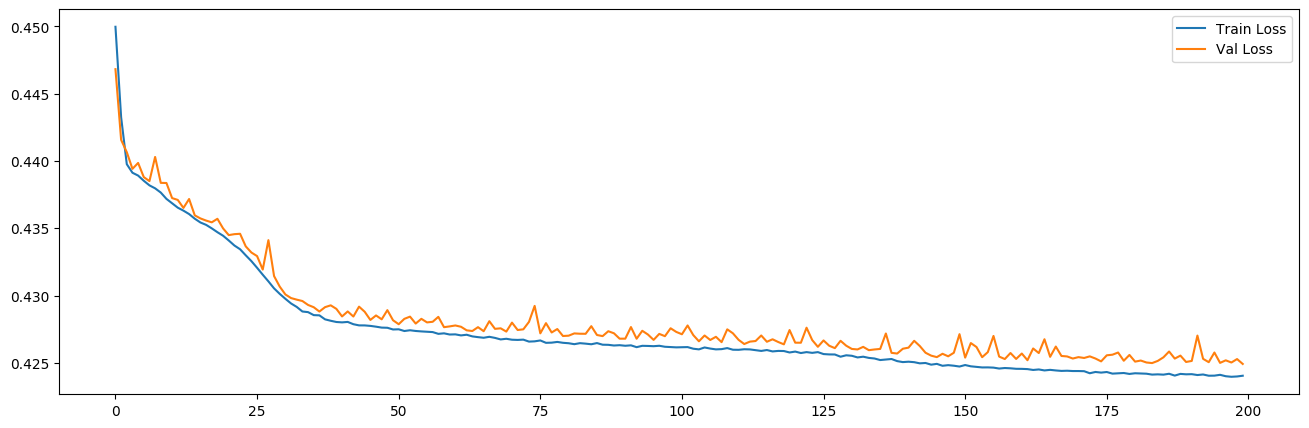

In [11]:
# Plot train and val loss
plt.figure(figsize=(16, 5))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Val Loss')
plt.legend()
plt.show()
